In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
np.random.seed(1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train.shape

(60000, 28, 28)


(60000, 28, 28, 1)

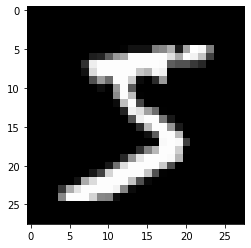

In [2]:
# channels, width, height
_input_img = x_train[0] #np.random.rand(28,28,3)
_input_size = _input_img.shape

plt.imshow(_input_img, cmap='gray')

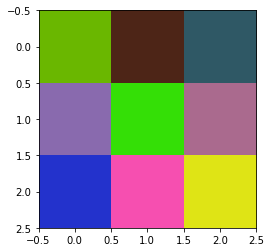

In [3]:
_num_kernels = 3
_kernel_size = 3
_kernels = np.random.rand(_kernel_size,_kernel_size,_num_kernels)
plt.imshow(_kernels, cmap='gray')

(32, 32, 1)

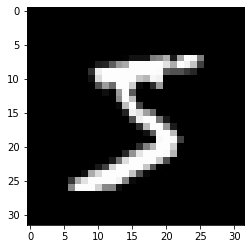

In [4]:
def apply_1d_padding(row, kernel_size):
    padding = kernel_size//2
    channels = row.shape[-1]
    return np.concatenate([np.zeros(shape=(padding,channels)), row, np.zeros(shape=(padding,channels))])

def apply_2d_padding(input_img, kernel_size):
    width = input_img.shape[1]
    channels = input_img.shape[2]
    padding = kernel_size//2
    
    pad_sides = np.stack([apply_1d_padding(row,kernel_size) for row in input_img])
    zeros = np.zeros(shape=(padding,width+2*padding,channels))
    pad_full = np.vstack([zeros, pad_sides, zeros])
    return pad_full

_padded_img = apply_2d_padding(_input_img, 5)
plt.imshow(_padded_img, cmap='gray')
_padded_img.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 28, 3)

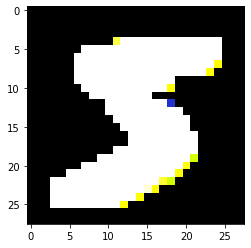

In [5]:
# Forward pass
def forward_propagation(input_img, kernels, num_kernels, kernel_size, input_size):
    output = np.zeros(shape=(input_size[0], input_size[1], num_kernels))
    input_pad = apply_2d_padding(input_img, kernel_size)

    for i_w in range(input_img.shape[0]): # img width
        for i_h in range(input_img.shape[1]): # img height
            for k_w in range(kernel_size):
                for k_h in range(kernel_size):
                    for i in range(input_img.shape[2]): # input channels
                        for k in range(num_kernels): # output channels
                            output[i_w][i_h][k] += kernels[k_w][k_h][k] * input_pad[i_w+k_w][i_h+k_h][i]
                            
    return output

_output = forward_propagation(_input_img, _kernels, _num_kernels, _kernel_size, _input_size)
plt.imshow(_output, cmap='gray')
_output.shape

In [12]:
# Backward Pass
def backward_propagation_input(input_img, kernels, num_kernels, kernel_size, output, output_grad, learning_rate):
    output_grad_pad = apply_2d_padding(output_grad, kernel_size)

    input_grad = np.zeros_like(input_img)    
    for i_w in range(input_img.shape[0]): # img width
        for i_h in range(input_img.shape[1]): # img height
            for k_w in range(kernel_size):
                for k_h in range(kernel_size):
                    for i in range(input_img.shape[2]): # input channels
                        for k in range(num_kernels): # output channels
                            input_grad[i_w][i_h][i] += output_grad_pad[i_w+kernel_size-k_w-1][i_h+kernel_size-k_h-1][k] * kernels[k_w][k_h][k]

    return input_grad

def backward_propagation_kernels(input_img, kernels, num_kernels, kernel_size, output, output_grad, learning_rate):
    # kernel gradient
    kernels_grad = np.zeros_like(kernels)

    input_pad = apply_2d_padding(input_img, kernel_size)
    
    for i_w in range(input_img.shape[0]): # img width
        for i_h in range(input_img.shape[1]): # img height
            for k_w in range(kernel_size):
                for k_h in range(kernel_size):
                    for i in range(input_img.shape[2]): # input channels
                        for k in range(num_kernels): # output channels
                            kernels_grad[k_w][k_h][k] += input_pad[i_w+k_w][i_h+k_h][i] * output_grad[k_w][k_h][k]

    return kernels_grad

#backward_propagation_input(_output, _output, 0.001)

In [13]:
# Test gradients
_input_img2 = _input_img.copy()
x = np.random.randint(_input_img.shape[0])
y = np.random.randint(_input_img.shape[1])
z = np.random.randint(_input_img.shape[2])
print((x,y,z))
_input_img2[x][y][z] += 1
#print(_input_img)
#print(_input_img2)

_output = forward_propagation(_input_img, _kernels, _num_kernels, _kernel_size, _input_size)
_output2 = forward_propagation(_input_img2, _kernels, _num_kernels, _kernel_size, _input_size)

#print(_output - _output2)
s1 = _output.sum()
s2 = _output2.sum()
print(s2-s1)

(25, 8, 0)
11.97640790604055


In [14]:
_output_error = np.ones_like(_output)

_input_grad = backward_propagation_input(_input_img, _kernels, _num_kernels, _kernel_size, _output, _output_error, 0.001)
_input_grad[x][y][z]

11.976408

In [15]:
_kernels2 = _kernels.copy()
x = np.random.randint(_kernels.shape[0])
y = np.random.randint(_kernels.shape[1])
z = np.random.randint(_kernels.shape[2])
_kernels2[x][y][z] += 1

_output = forward_propagation(_input_img, _kernels, _num_kernels, _kernel_size, _input_size)
_output2 = forward_propagation(_input_img, _kernels2, _num_kernels, _kernel_size, _input_size)
s1 = _output.sum()
s2 = _output2.sum()
print(s2-s1)

27525.0


In [16]:
_kernels_grad = backward_propagation_kernels(_input_img, _kernels, _num_kernels, _kernel_size, _output, _output_error, 0.001)
_kernels_grad[x][y][z]

27525.0

In [18]:
# flatten operation
flat = _input_img.reshape(-1)
flat

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   